# Tracking speed - Benchmarks

*Latest update: 2023.03.04*



In this experiment, we evaluate the tracking performance of:

* MLflow - https://mlflow.org/
* FastTrackML - https://github.com/G-Research/fasttrackml
* WandB - https://wandb.ai/
* Neptune - https://neptune.ai/
* Aim - https://aimstack.io/
* Comet - https://www.comet.com/
* MLtraq - https://mltraq.com/

Varying:

* Number of runs tracked
* Number of values tracked

Configuration:
* Keeping the number of experiments fixed to `1` (not all methods model both experiments and runs)
* Tracking `float` values, disabling everything else such as git, code, environment and system stats
* Experiments running/tracking offline, logging disabled, storage on local filesystem
* Every experiment starts with an empty directory for storage
* Results averaged on `10` runs

Comments:
* FastTrackML requires a running server, the command used is `fml server --log-level error`. The results on "start-up time" for FastTrackML ignore the cost of starting up the server (which creates a SQLite file, schema compatible with MLflow).


## Imports and utility functions

In [1]:
%load_ext pyinstrument

In [2]:
import logging
import shutil
import threading
import uuid
from contextlib import contextmanager, redirect_stderr, redirect_stdout
from os import devnull, environ, makedirs, remove

import aim
import comet_ml
import fasttrackml
import matplotlib.pyplot as plt
import mlflow
import mltraq
import neptune
import pandas as pd
import wandb
from mltraq.utils.plot import bar_plot

In [3]:
# Versions

print("mlflow", mlflow.__version__)
print("neptune", neptune.__version__)
print("wandb", wandb.__version__)
print("aim", aim.__version__.__version__)
print("comet", comet_ml.__version__)
print("mltraq", mltraq.__version__)
print("fasttrackml", "0.5.0b2")

mlflow 2.11.0
neptune 1.9.1
wandb 0.16.3
aim 3.18.1
comet 3.38.1
mltraq 0.0.121
fasttrackml 0.5.0b2


In [4]:
# Utility functions


@contextmanager
def suppress_stdout_stderr():
    """
    A context manager that redirects stdout and stderr to devnull.
    """
    with open(devnull, "w") as fnull:
        with redirect_stderr(fnull) as err, redirect_stdout(fnull) as out:
            yield (err, out)


def remove_file(pathname):
    """
    Remove file `pathname` if existing.
    """
    try:
        remove(pathname)
    except OSError:
        pass


def create_dir(pathdir):
    """
    Create `pathdir` recursively. If it already exists, do nothing.
    """
    makedirs(pathdir, exist_ok=True)

## Test procedure for WandB

In [5]:
def test_wandb(n_experiments=1, n_runs=1, n_values=1):
    """
    Test Weights & Biases tracking with a specified number of experiments, runs and values.
    """

    # Required to silence Python output and disable sentry tracking.
    # This must be inside the test function to propagate to child processes.
    environ["WANDB_SILENT"] = "true"
    environ["WANDB_ERROR_REPORTING"] = "false"
    environ["WANDB_DISABLE_GIT"] = "true"
    environ["DISABLE_CODE"] = "true"

    tmp_dir = f"tmp/{uuid.uuid4()}"
    create_dir(f"{tmp_dir}/wandb")
    for _ in range(n_experiments):
        experiment_id = str(uuid.uuid4())
        for _ in range(n_runs):
            run_id = str(uuid.uuid4())
            wandb.init(
                project=experiment_id,
                group=run_id,
                dir=tmp_dir,
                mode="offline",
            )
            for _ in range(n_values):
                wandb.log({"value": 123.45})
    wandb.finish()

In [6]:
%%pyinstrument
test_wandb()


_     ._   __/__   _ _  _  _ _/_   Recorded: 18:23:39  Samples:  174
 /_//_/// /_\ / //_// / //_'/ //     Duration: 2.216     CPU time: 0.251
/   _/                      v4.6.2

Program: /Users/michele/dev/mltraq/.venv/lib/python3.11/site-packages/ipykernel_launcher.py -f /Users/michele/Library/Jupyter/runtime/kernel-49dfa40d-b2f9-400e-9297-347e546792ae.json

2.215 <module>  ../../../../../var/folders/2c/7zw87mvd2c386jc15bltj_qm0000gp/T/ipykernel_92802/1666376201.py:1
`- 2.215 test_wandb  ../../../../../var/folders/2c/7zw87mvd2c386jc15bltj_qm0000gp/T/ipykernel_92802/581603400.py:1
   |- 1.578 finish  wandb/sdk/wandb_run.py:4108
   |     [28 frames hidden]  wandb, threading, <built-in>, sentry_sdk
   |        1.002 lock.acquire  <built-in>
   `- 0.636 init  wandb/sdk/wandb_init.py:940
         [36 frames hidden]  wandb, <built-in>, jupyter_server, re

## Test procedure for MLflow

In [7]:
def test_mlflow(n_experiments=1, n_runs=1, n_values=1):
    """
    Test MLflow tracking with a specified number of experiments, runs and values.
    """

    create_dir("tmp")
    db_fname = f"tmp/{uuid.uuid4()}.db"
    mlflow.set_tracking_uri(f"sqlite:///{db_fname}")
    for _ in range(n_experiments):
        experiment_id = mlflow.create_experiment(str(uuid.uuid4()))
        for _ in range(n_runs):
            with mlflow.start_run(experiment_id=experiment_id):
                for _ in range(0, n_values):
                    mlflow.log_metric(key="value", value=123.45)
            mlflow.end_run()
    remove_file(db_fname)

In [8]:
%%pyinstrument
test_mlflow()


2024/03/04 18:23:44 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2024/03/04 18:23:44 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Running upgrade  -> 451aebb31d03, add metric step
INFO  [alembic.runtime.migration] Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
INFO  [alembic.runtime.migration] Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
INFO  [alembic.runtime.migration] Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
INFO  [alembic.runtime.migration] Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
INFO  [alembic.runtime.migration] Running upgrade 7ac759974ad8 -> 89d4b8295536, create latest metrics table
INFO  [89d4b8295536_create_latest_metrics_table_py] Migration complete!
INFO  

_     ._   __/__   _ _  _  _ _/_   Recorded: 18:23:44  Samples:  394
 /_//_/// /_\ / //_// / //_'/ //     Duration: 1.879     CPU time: 0.634
/   _/                      v4.6.2

Program: /Users/michele/dev/mltraq/.venv/lib/python3.11/site-packages/ipykernel_launcher.py -f /Users/michele/Library/Jupyter/runtime/kernel-49dfa40d-b2f9-400e-9297-347e546792ae.json

1.878 <module>  ../../../../../var/folders/2c/7zw87mvd2c386jc15bltj_qm0000gp/T/ipykernel_92802/2371405818.py:1
`- 1.878 test_mlflow  ../../../../../var/folders/2c/7zw87mvd2c386jc15bltj_qm0000gp/T/ipykernel_92802/625529744.py:1
   |- 1.325 ActiveRun.__exit__  mlflow/tracking/fluent.py:195
   |     [13 frames hidden]  mlflow, comet_ml, threading, <built-in>
   |        1.088 lock.acquire  <built-in>
   |- 0.407 create_experiment  mlflow/tracking/fluent.py:1601
   |     [46 frames hidden]  mlflow, alembic, sqlalchemy, mako, <s...
   `- 0.146 wrapper  comet_ml/monkey_patching.py:261
         [12 frames hidden]  comet_ml, <built-in>, mlflow

## Test procedure for FastTrackML

In [11]:
# requires `fml server --log-level error`
def test_fasttrackml(n_experiments=1, n_runs=1, n_values=1):
    """
    Test FastTrackML tracking with a specified number of experiments, runs and values.
    """

    fasttrackml.set_tracking_uri("http://localhost:5000")
    client = fasttrackml.FasttrackmlClient()
    for i in range(n_experiments):
        experiment_id = str(i)
        for _ in range(n_runs):
            run = client.create_run(experiment_id)
            run_id = run.info.run_id
            for _ in range(0, n_values):
                client.log_metric(run_id, "value", 123.45)
        client.set_terminated(run_id)

In [12]:
%%pyinstrument
test_fasttrackml()

_     ._   __/__   _ _  _  _ _/_   Recorded: 18:24:21  Samples:  24
 /_//_/// /_\ / //_// / //_'/ //     Duration: 0.028     CPU time: 0.025
/   _/                      v4.6.2

Program: /Users/michele/dev/mltraq/.venv/lib/python3.11/site-packages/ipykernel_launcher.py -f /Users/michele/Library/Jupyter/runtime/kernel-49dfa40d-b2f9-400e-9297-347e546792ae.json

0.027 <module>  ../../../../../var/folders/2c/7zw87mvd2c386jc15bltj_qm0000gp/T/ipykernel_92802/2744998001.py:1
`- 0.027 test_fasttrackml  ../../../../../var/folders/2c/7zw87mvd2c386jc15bltj_qm0000gp/T/ipykernel_92802/1747381839.py:2
   |- 0.014 FasttrackmlClient.create_run  mlflow/tracking/client.py:299
   |     [59 frames hidden]  mlflow, requests, urllib3, http, sock...
   |- 0.006 FasttrackmlClient.log_metric  fasttrackml/client.py:19
   |     [42 frames hidden]  fasttrackml, mlflow, requests, urllib...
   |- 0.005 FasttrackmlClient.set_terminated  mlflow/tracking/client.py:1938
   |     [32 frames hidden]  mlflow, requests, urllib3, http, sock...
   `- 0.001 FasttrackmlClient.__init__  fasttrackml/client.py:13
         [7 frames hidden]  fasttrackml, mlflow, <built-in>

## Test procedure for Neptune

In [13]:
def test_neptune(n_experiments=1, n_runs=1, n_values=1):
    """
    Test Neptune tracking with a specified number of experiments, runs and values.
    """

    for _ in range(n_experiments):
        # No "experiment" concept in Neptune, and we cannot create "projects" offline on the free plan.
        # Also, not easy to set a custom directory, it will log things in .neptune/
        for _ in range(n_runs):
            run = neptune.init_run(
                project=f"workspace/{str(uuid.uuid4())}",
                mode="offline",
                git_ref=False,
            )
            for _ in range(0, n_values):
                run["value"].append(123.45)
            run.wait()
            run.stop()

In [14]:
%%pyinstrument
test_neptune()

[neptune] [info   ] Neptune initialized. Open in the app: offline/5cc77223-9b03-4bf6-a474-49c9060a6818
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!


[neptune] [warning] NeptuneWarning: The following monitoring options are disabled by default in interactive sessions: 'capture_stdout', 'capture_stderr', 'capture_traceback', and 'capture_hardware_metrics'. To enable them, set each parameter to 'True' when initializing the run. The monitoring will continue until you call run.stop() or the kernel stops. Also note: Your source files can only be tracked if you pass the path(s) to the 'source_code' argument. For help, see the Neptune docs: https://docs.neptune.ai/logging/source_code/


_     ._   __/__   _ _  _  _ _/_   Recorded: 18:24:25  Samples:  27
 /_//_/// /_\ / //_// / //_'/ //     Duration: 0.048     CPU time: 0.027
/   _/                      v4.6.2

Program: /Users/michele/dev/mltraq/.venv/lib/python3.11/site-packages/ipykernel_launcher.py -f /Users/michele/Library/Jupyter/runtime/kernel-49dfa40d-b2f9-400e-9297-347e546792ae.json

0.047 <module>  ../../../../../var/folders/2c/7zw87mvd2c386jc15bltj_qm0000gp/T/ipykernel_92802/3214493869.py:1
`- 0.047 test_neptune  ../../../../../var/folders/2c/7zw87mvd2c386jc15bltj_qm0000gp/T/ipykernel_92802/3319462458.py:1
   |- 0.045 Run.__init__  neptune/metadata_containers/run.py:307
   |     [93 frames hidden]  neptune, logging, ipykernel, zmq, thr...
   |- 0.001 Handler.inner_fun  neptune/handler.py:85
   |     [13 frames hidden]  neptune, <built-in>
   `- 0.001 Run.stop  neptune/metadata_containers/metadata_container.py:410
         [2 frames hidden]  neptune

## Test procedure for Aim

In [15]:
def test_aim(n_experiments=1, n_runs=1, n_values=1):
    """
    Test Aim tracking with a specified number of experiments, runs and values.
    """

    create_dir("tmp/aim/")
    repo = f"tmp/aim/{uuid.uuid4()}"
    for _ in range(n_experiments):
        for _ in range(n_runs):
            run_id = str(uuid.uuid4())
            # Doc: https://aimstack.readthedocs.io/en/latest/refs/sdk.html#aim.sdk.run.Run
            # Experiments in Aim match to what we call runs in this notebook.
            run = aim.Run(
                repo=repo,
                experiment=run_id,
                system_tracking_interval=None,
                capture_terminal_logs=False,
            )
            for _ in range(0, n_values):
                run.track({"value": 123.45})

In [16]:
%%pyinstrument
test_aim()

_     ._   __/__   _ _  _  _ _/_   Recorded: 18:24:28  Samples:  49
 /_//_/// /_\ / //_// / //_'/ //     Duration: 0.763     CPU time: 0.071
/   _/                      v4.6.2

Program: /Users/michele/dev/mltraq/.venv/lib/python3.11/site-packages/ipykernel_launcher.py -f /Users/michele/Library/Jupyter/runtime/kernel-49dfa40d-b2f9-400e-9297-347e546792ae.json

0.762 <module>  ../../../../../var/folders/2c/7zw87mvd2c386jc15bltj_qm0000gp/T/ipykernel_92802/3340399674.py:1
|- 0.700 test_aim  ../../../../../var/folders/2c/7zw87mvd2c386jc15bltj_qm0000gp/T/ipykernel_92802/1876961650.py:1
|  `- 0.700 wrapper  aim/ext/exception_resistant.py:65
|        [43 frames hidden]  aim, subprocess, <built-in>, sqlalchemy
|           0.404 waitpid  <built-in>
`- 0.062 finalize.__call__  weakref.py:585
      [2 frames hidden]  weakref

## Test procedure for Comet

In [72]:
def test_comet(n_experiments=1, n_runs=1, n_values=1):
    """
    Test Comet tracking with a specified number of experiments, runs and values.
    """

    tmp_dir = f"tmp/comet/{uuid.uuid4()}"
    create_dir(tmp_dir)
    for _ in range(n_experiments):
        experiment_id = str(uuid.uuid4())
        for _ in range(n_runs):
            run_id = str(uuid.uuid4().hex)  # Only alphanum IDs for Comet experiments, which match our semantics of runs
            run = comet_ml.OfflineExperiment(
                project_name=experiment_id,
                log_code=False,
                log_graph=False,
                log_env_gpu=False,
                log_env_cpu=False,
                log_env_network=False,
                log_env_disk=False,
                log_env_host=False,
                log_git_metadata=False,
                offline_directory=tmp_dir,
                experiment_key=run_id,
                display_summary_level=0,
            )
            for _ in range(0, n_values):
                run.log_metrics({"value": 123.45})
            run.end()

In [73]:
%%pyinstrument
test_comet()

_     ._   __/__   _ _  _  _ _/_   Recorded: 14:04:07  Samples:  14
 /_//_/// /_\ / //_// / //_'/ //     Duration: 0.160     CPU time: 0.088
/   _/                      v4.6.2

Program: /Users/michele/dev/mltraq/.venv/lib/python3.11/site-packages/ipykernel_launcher.py -f /Users/michele/Library/Jupyter/runtime/kernel-49dfa40d-b2f9-400e-9297-347e546792ae.json

0.159 <module>  ../../../../../var/folders/2c/7zw87mvd2c386jc15bltj_qm0000gp/T/ipykernel_92802/3382937944.py:1
`- 0.159 test_comet  ../../../../../var/folders/2c/7zw87mvd2c386jc15bltj_qm0000gp/T/ipykernel_92802/3417524710.py:1
   |- 0.148 OfflineExperiment.end  comet_ml/experiment.py:687
   |     [7 frames hidden]  comet_ml, <built-in>
   |        0.090 unregister  <built-in>
   |        0.055 sleep  <built-in>
   `- 0.011 OfflineExperiment.__init__  comet_ml/offline.py:231
         [9 frames hidden]  comet_ml, <built-in>

## Test procedure for MLtraq

In [19]:
def test_mltraq(n_experiments=1, n_runs=1, n_values=1):
    """
    Test MLtraq tracking with a specified number of experiments, runs and values.
    """

    create_dir("tmp")
    db_fname = f"tmp/{uuid.uuid4()}.db"
    session = mltraq.create_session(f"sqlite:///{db_fname}")
    with mltraq.options().ctx({"tqdm.disable": True}):
        for _ in range(n_experiments):
            experiment = session.create_experiment()
            for _ in range(n_runs):
                with experiment.run() as run:
                    run.fields.value = []
                    for _ in range(0, n_values):
                        run.fields.value.append(123.45)
            experiment.persist()
    remove_file(db_fname)

In [20]:
%%pyinstrument
test_mltraq()

_     ._   __/__   _ _  _  _ _/_   Recorded: 18:24:34  Samples:  36
 /_//_/// /_\ / //_// / //_'/ //     Duration: 0.041     CPU time: 0.043
/   _/                      v4.6.2

Program: /Users/michele/dev/mltraq/.venv/lib/python3.11/site-packages/ipykernel_launcher.py -f /Users/michele/Library/Jupyter/runtime/kernel-49dfa40d-b2f9-400e-9297-347e546792ae.json

0.041 <module>  ../../../../../var/folders/2c/7zw87mvd2c386jc15bltj_qm0000gp/T/ipykernel_92802/2389778167.py:1
`- 0.041 test_mltraq  ../../../../../var/folders/2c/7zw87mvd2c386jc15bltj_qm0000gp/T/ipykernel_92802/1091169221.py:1
   |- 0.031 Experiment.persist  mltraq/experiment.py:364
   |  |- 0.016 Experiment.delete  mltraq/experiment.py:397
   |  |  |- 0.010 Query.count  sqlalchemy/orm/query.py:3053
   |  |  |     [86 frames hidden]  sqlalchemy, <built-in>
   |  |  |- 0.004 Database.drop_table  mltraq/storage/database.py:170
   |  |  |  |- 0.003 MetaData.reflect  sqlalchemy/sql/schema.py:5619
   |  |  |  |     [30 frames hidden]  sqlalchemy, <string>
   |  |  |  `- 0.001 Table.drop  sqlalchemy/sql/schema.py:1290
   |  |  |        [13 frames hidden]  sqlalchemy, <built-in>
   |  |  |- 0.001 Session.commit  sqlalchemy/orm/session.py:1936
   |  |  |     [6 frames hidden]  sqlalchemy, <string>, <frozen _collec...
   |  |  `- 0.001 [self]  mltraq/experiment.py
   |  |- 0.007 runs_to_sql  mltraq/storage/serialization.py:111
   |  |  |- 0.005 Runs.df  mltraq/runs.py:66
   |  |  |  |- 0.003 json_normalize  pandas/io/json/_normalize.py:245
   |  |  |  |     [11 frames hidden]  pandas, <frozen abc>
   |  |  |  `- 0.002 reorder_columns  mltraq/utils/frames.py:6
   |  |  |     `- 0.002 DataFrame.__getitem__  pandas/core/frame.py:4050
   |  |  |           [15 frames hidden]  pandas
   |  |  |- 0.001 reorder_columns  mltraq/utils/frames.py:6
   |  |  |  `- 0.001 DataFrame.__getitem__  pandas/core/frame.py:4050
   |  |  |        [5 frames hidden]  pandas
   |  |  `- 0.001 Series.map  pandas/core/series.py:4611
   |  |        [2 frames hidden]  pandas
   |  |- 0.004 Database.pandas_to_sql  mltraq/storage/database.py:128
   |  |  `- 0.004 wrapper  pandas/util/_decorators.py:325
   |  |        [41 frames hidden]  pandas, sqlalchemy, <built-in>, conte...
   |  |- 0.002 Session.commit  sqlalchemy/orm/session.py:1936
   |  |     [25 frames hidden]  sqlalchemy, <string>, <built-in>
   |  `- 0.001 Experiment.record  mltraq/experiment.py:333
   |     `- 0.001 serialize  mltraq/storage/serialization.py:40
   |        `- 0.001 DataPakSerializer.serialize  mltraq/storage/serializers/datapak.py:95
   |           `- 0.001 PickleSerializer.serialize  mltraq/storage/serializers/pickle.py:42
   |              `- 0.001 assert_safe  mltraq/storage/serializers/pickle.py:31
   |                 `- 0.001 <setcomp>  mltraq/storage/serializers/pickle.py:37
   |- 0.009 Session.__init__  mltraq/session.py:22
   |  `- 0.009 Database.__init__  mltraq/storage/database.py:44
   |     |- 0.007 MetaData.create_all  sqlalchemy/sql/schema.py:5801
   |     |     [68 frames hidden]  sqlalchemy, <built-in>, contextlib, <...
   |     |- 0.001 Database.init_url  mltraq/storage/database.py:91
   |     |  `- 0.001 make_url  sqlalchemy/engine/url.py:825
   |     |        [3 frames hidden]  sqlalchemy, <built-in>
   |     `- 0.001 create_engine  <string>:1
   |           [7 frames hidden]  <string>, sqlalchemy
   `- 0.001 Session.create_experiment  mltraq/session.py:59
      `- 0.001 Experiment.__init__  mltraq/experiment.py:67
         `- 0.001 next_uuid  mltraq/storage/database.py:302
            `- 0.001 uuid4  uuid.py:721
                  [2 frames hidden]  uuid

## Defining the experiment

In [69]:
def eval_time(run: mltraq.Run):
    """
    Measure the time required to track a set of experiments.
    """

    # Disable logging
    logging.disable()

    with suppress_stdout_stderr():
        log = mltraq.Sequence()

        # Start tracking time.
        log.append(tag="begin")
        if run.params.method == "FastTrackML":
            test_fasttrackml(
                n_experiments=run.params.n_experiments,
                n_runs=run.params.n_runs,
                n_values=run.params.n_values,
            )
        elif run.params.method == "MLflow":
            test_mlflow(
                n_experiments=run.params.n_experiments,
                n_runs=run.params.n_runs,
                n_values=run.params.n_values,
            )
        elif run.params.method == "MLtraq":
            test_mltraq(
                n_experiments=run.params.n_experiments,
                n_runs=run.params.n_runs,
                n_values=run.params.n_values,
            )
        elif run.params.method == "Neptune":
            test_neptune(
                n_experiments=run.params.n_experiments,
                n_runs=run.params.n_runs,
                n_values=run.params.n_values,
            )
        elif run.params.method == "WandB":
            test_wandb(
                n_experiments=run.params.n_experiments,
                n_runs=run.params.n_runs,
                n_values=run.params.n_values,
            )
        elif run.params.method == "Aim":
            test_aim(
                n_experiments=run.params.n_experiments,
                n_runs=run.params.n_runs,
                n_values=run.params.n_values,
            )
        elif run.params.method == "Comet":
            test_comet(
                n_experiments=run.params.n_experiments,
                n_runs=run.params.n_runs,
                n_values=run.params.n_values,
            )
        else:
            raise Exception("unknown method")

        log.append(tag="end")
        durations = log.df().pivot_table(index="tag", values="timestamp")["timestamp"]
        run.fields.duration = (durations.end - durations.begin).total_seconds()
        run.fields.n_threads = threading.active_count()
        run.fields |= run.params


def cleanup(run: mltraq.Run):
    # Remove temporary files
    shutil.rmtree(".neptune", ignore_errors=True)
    shutil.rmtree(".cometml-runs", ignore_errors=True)
    shutil.rmtree("mlruns", ignore_errors=True)
    shutil.rmtree("tmp", ignore_errors=True)

## Defining the plots

In [71]:
def report_results(experiment: mltraq.Experiment, save_svg_to=None):
    """
    Given an executed experiment, report the results with a plot and a table.
    """

    fig, (ax1, ax2, ax3) = plt.subplots(figsize=[10, 2], nrows=1, ncols=3)
    fig.tight_layout()
    with mltraq.options().ctx(
        {
            "matplotlib.rc": {"hatch.color": "white"},
            "matplotlib.style": "tableau-colorblind10",
        }
    ):

        bar_plot(
            experiment.runs.df(),
            x="n_runs",
            x_label="Number of runs",
            y="duration",
            yerr=True,
            y_label="Duration (s)",
            group="method",
            ax=ax1,
            y_lim={"bottom": 0},
            hatches=False,
            legend={
                "loc": "lower center",
                "bbox_to_anchor": (0.5, -1.1),
                "fancybox": True,
                "shadow": False,
                "ncol": 2,
            },
        )

        bar_plot(
            experiment.runs.df(),
            x="n_values",
            x_label="Number of values",
            y="duration",
            yerr=True,
            group="method",
            ax=ax2,
            y_label="duration (s)",
            y_lim={"bottom": 0},
            hatches=False,
            legend={
                "loc": "lower center",
                "bbox_to_anchor": (0.5, -1.1),
                "fancybox": True,
                "shadow": False,
                "ncol": 2,
            },
        )
        ax2.yaxis.label.set_visible(False)

        bar_plot(
            experiment.runs.df(),
            x="method",
            x_label="Method",
            y="duration",
            yerr=True,
            ax=ax3,
            y_lim={"bottom": 0},
        )
        ax3.yaxis.label.set_visible(False)
        ax3.tick_params(axis="x", labelrotation=45)

    if save_svg_to:
        plt.savefig(save_svg_to, bbox_inches="tight", pad_inches=0.1)

    plt.show()

    # Display aggregated results table (duration and multiplier to the best-performing method)
    print("\nAveraged results by method\n")
    df = experiment.runs.df().groupby("method")["duration"].mean().sort_values().to_frame()
    df["ratio_to_best"] = df["duration"] / df["duration"].iloc[0]
    display(df)
    print("\n")

## Experiments

* In the rest of the notebook, we experiment varying number of experiments, runs and values.
* With some differences, all methods capture these parameters.


In [23]:
# Create an MLtraq session to track the benchmarks
session = mltraq.create_session("sqlite:///local/benchmarks_rev1.db")

### Experiment 1: How long does tracking a single value take?

In this experiment, we evaluate the time required to start a new experiment and track a single value.
This experiment lets us compare the start-up time of the methods, regardless of how many values we track.
FastTrackML requires a running web server (executed with `fml server --log-level error`).

In [28]:
e = session.create_experiment("exp-1", if_exists="replace")
e.add_runs(
    method=[
        "Aim",
        "Comet",
        "WandB",
        "Neptune",
        "MLtraq",
        "MLflow",
        "FastTrackML",
    ],
    i=range(10),
    n_experiments=[1],
    n_runs=[1],
    n_values=[1, 10],
)

# Parallelization is disabled as it might affect results.
e.execute([cleanup, eval_time, cleanup], n_jobs=1).persist(if_exists="replace")

  1%|          | 1/140 [00:01<03:26,  1.49s/it]

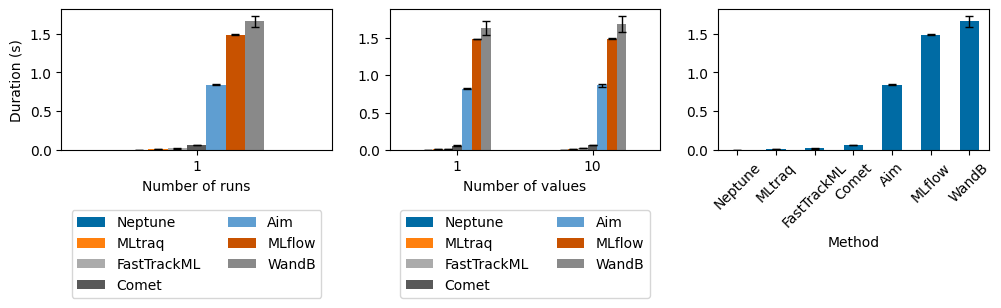


Averaged results by method



,duration,ratio_to_best
method,,
Neptune,0.004151,1.000000
MLtraq,0.014749,3.553613
FastTrackML,0.022375,5.390972
Comet,0.062093,14.960138
Aim,0.843322,203.183120
MLflow,1.484595,357.686403
WandB,1.656235,399.039862


In [47]:
# Report results
report_results(session.load("exp-1"))

The analysis of the test procedures with `pyinstrument` reveals where most of the time is spent for each method:

* WandB and MLflow are the worst performing, with time dominated by threading, events/databases management.
* Aim follows by spending most of the time creating and managing the database.
* Comet is next, with threading management taking most of the time.
* FastTrackML is remarkably fast to create new runs, offering API compatibility with MLFlow. It is fast also because it requires a server running in the background, eliminating most of the startup cost.
* MLtraq spends most of the time writing to SQLite, with no threading. Again, database management is expensive.
* Comet is the best performing, with no threading, no SQLite database, simply writing the tracking data to disk. The least you do, the fastest you do it.

In summary, the less you do to start up, the faster you are. Threading and communication are expensive, as well as database management.

### Experiment 2: How much time to track 100-100K values?

In [36]:
e = session.create_experiment("exp-2")
e.add_runs(
    method=[
        "Aim",
        "Comet",
        "WandB",
        "Neptune",
        "MLtraq",
        "MLflow",
        "FastTrackML",
    ],
    i=range(10),
    n_experiments=[1],
    n_runs=[1],
    n_values=[10**2, 10**3, 10**4],
)

# Parallelization disabled as it might affect results.
e.execute([cleanup, eval_time, cleanup], n_jobs=1).persist(if_exists="replace")

  0%|          | 1/210 [00:14<51:59, 14.93s/it]

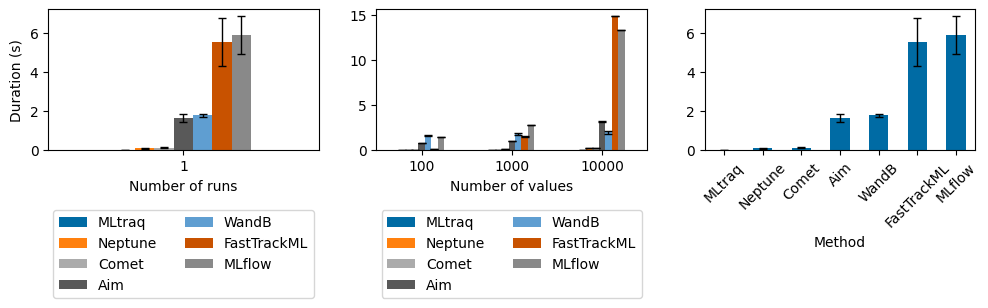


Averaged results by method



,duration,ratio_to_best
method,,
MLtraq,0.016536,1.000000
Neptune,0.090750,5.488035
Comet,0.122836,7.428430
Aim,1.648441,99.688215
WandB,1.786025,108.008521
FastTrackML,5.522108,333.945281
MLflow,5.870272,355.000222


In [37]:
# Report results
report_results(session.load("exp-2"))

* Performance changes dramatically, with WandB, MLflow, FastTrackML and Aim being the worst performing, either due to thread communication (WandB, Aim) or database management (MLflow, FastTrackML). MLflow and FastTrackML have the same database schema, which is rather expensive to maintain.
* Comet is next, followed by Neptune and MLtraq.

The advantage of MLtraq is in how the data is tracked and stored. Being very close to simply adding an element to an array and serializing it to an SQLite column value with the speedy DATAPAK serialization strategy, it is hard to beat.

### Experiment 3: How much time to track 10 runs?

In [38]:
e = session.create_experiment("exp-3")
e.add_runs(
    method=[
        "Aim",
        "Comet",
        "WandB",
        "Neptune",
        "MLtraq",
        "MLflow",
        "FastTrackML",
    ],
    i=range(10),
    n_experiments=[1],
    n_runs=[10],
    n_values=[1],
)

# Parallelization is disabled as it might affect results.
e.execute([cleanup, eval_time, cleanup], n_jobs=1).persist(if_exists="replace")

  1%|1         | 1/70 [00:04<05:23,  4.69s/it]

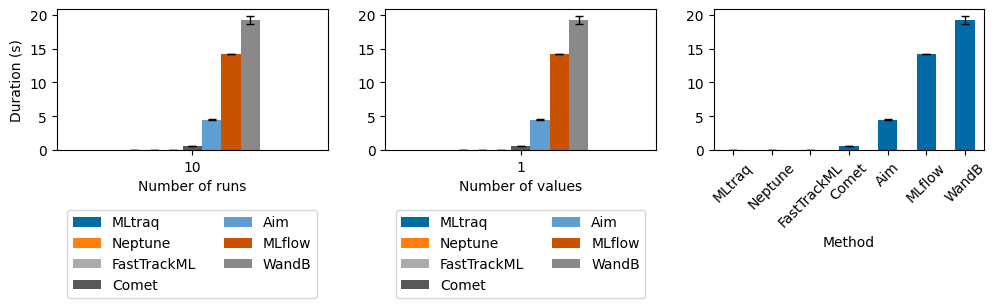


Averaged results by method



,duration,ratio_to_best
method,,
MLtraq,0.012304,1.000000
Neptune,0.017618,1.431907
FastTrackML,0.047559,3.865432
Comet,0.647103,52.593752
Aim,4.511088,366.641883
MLflow,14.165903,1151.343715
WandB,19.232946,1563.171183


In [39]:
# Report results
report_results(session.load("exp-3"))

The results are very similar to Experiment 1, with MLtraq now performing at the top.

* WandB, MLflow, Aim are the worst performing (as in Experiment 1). FastTrackML is handling the creation of new runs much faster than MLflow. This is where it shines.
* Neptune and Comet use the filesystem as a database, and MLtraq uses SQLite. As the number of files written by Neptune/Comet increases, it becomes more expensive than writing efficiently to a single database file. Writing to a single SQLite file can be 35% faster than writing to many filesystem files. See https://www.sqlite.org/fasterthanfs.html for more details.

* Comet creates a ZIP of the files to be uploaded to their cloud, which results in an additional time penalty.



### Experiment 4: How much time to track 100 runs?

In [40]:
e = session.create_experiment("exp-4")
e.add_runs(
    method=["Comet", "Neptune", "MLtraq", "FastTrackML"],
    i=range(10),
    n_experiments=[1],
    n_runs=[100],
    n_values=[1],
)

# Parallelization is disabled as it might affect results.
e.execute([cleanup, eval_time, cleanup], n_jobs=1).persist(if_exists="replace")

  2%|2         | 1/40 [00:00<00:06,  5.80it/s]

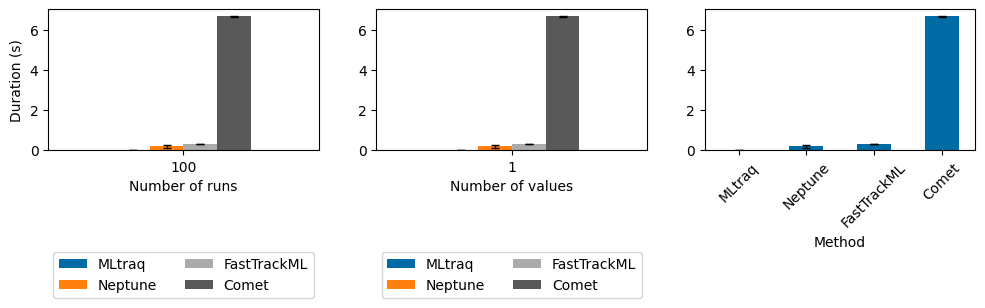


Averaged results by method



,duration,ratio_to_best
method,,
MLtraq,0.013279,1.000000
Neptune,0.183041,13.784342
FastTrackML,0.313169,23.583979
Comet,6.665897,501.991641


In [41]:
# Report results
report_results(session.load("exp-4"))

The results are very similar to Experiment 4. Creating hundreds of files, and zipping them, is very expensive for Comet. The other methods (MLFlow, WandB) have been excluded as they are orders of magnitude slower. They're out of the game.

### Experiment 5: How much time to track 1K runs and 1K values each?

In [ ]:
e = session.create_experiment("exp-5")
e.add_runs(
    method=["Neptune", "MLtraq"],
    i=range(10),
    n_experiments=[1],
    n_runs=[500, 1000],
    n_values=[500, 1000],
)

# Parallelization is disabled as it might affect results.
e.execute([cleanup, eval_time, cleanup], n_jobs=1).persist(if_exists="replace")

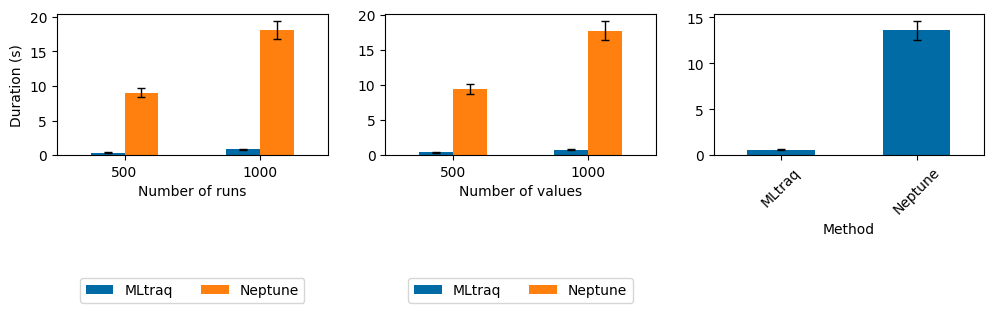


Averaged results by method



,duration,ratio_to_best
method,,
MLtraq,0.590053,1.000000
Neptune,13.579130,23.013418


In [49]:
# Report results
report_results(session.load("exp-5"))

* As we increase the number of tracked values or runs, MLtraq becomes more and more competitive. With no threading and no filesystem bottleneck, it is the fastest method for realistic workloads.
* With up to 1K runs and values, MLtraq is 23x faster than Neptune on average.
The other methods, WandB, Aim, Comet, MLflow and FastTrackML are orders of magnitude slower.

### Aggregates

In [50]:
# Warning: Aggregates on multiple experiments, not all methods used on all experiments.
dfs = [session.load(f"exp-{idx}").runs.df() for idx in [1, 2, 3, 4, 5]]
df = pd.concat(dfs).groupby("method").duration.mean().sort_values().to_frame()
df["ratio_to_best"] = df["duration"] / df["duration"].iloc[0]
df

,duration,ratio_to_best
method,,
MLtraq,0.224082,1.000000
Comet,1.115099,4.976303
Aim,1.857176,8.287935
FastTrackML,2.424543,10.819901
WandB,4.650582,20.753942
Neptune,4.981612,22.231214
MLflow,5.790985,25.843167


### Save plots to SVG files

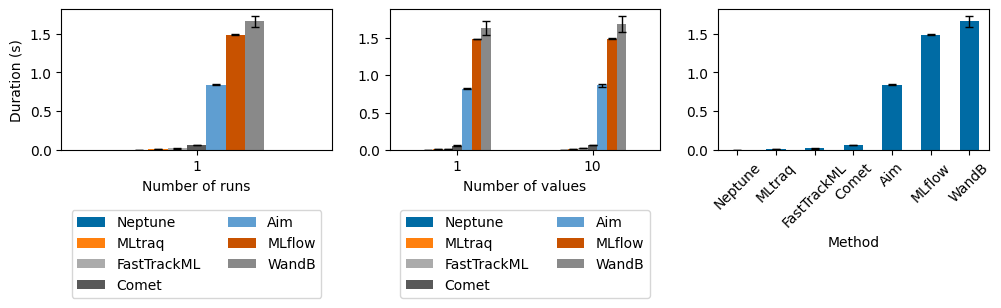


Averaged results by method



,duration,ratio_to_best
method,,
Neptune,0.004151,1.000000
MLtraq,0.014749,3.553613
FastTrackML,0.022375,5.390972
Comet,0.062093,14.960138
Aim,0.843322,203.183120
MLflow,1.484595,357.686403
WandB,1.656235,399.039862


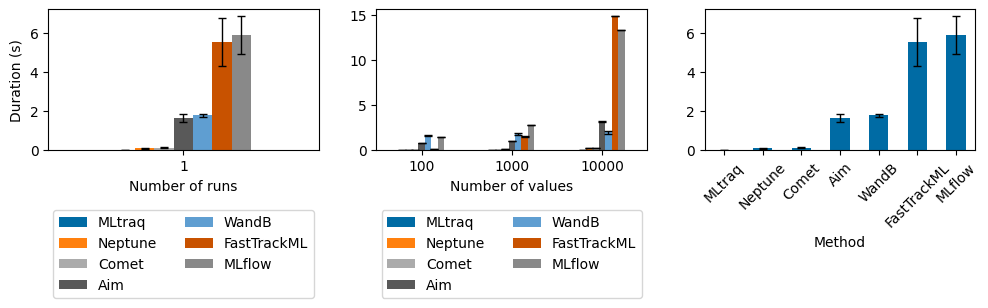


Averaged results by method



,duration,ratio_to_best
method,,
MLtraq,0.016536,1.000000
Neptune,0.090750,5.488035
Comet,0.122836,7.428430
Aim,1.648441,99.688215
WandB,1.786025,108.008521
FastTrackML,5.522108,333.945281
MLflow,5.870272,355.000222


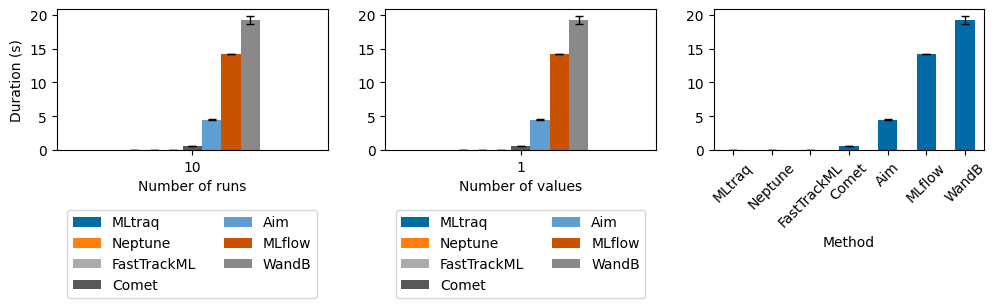


Averaged results by method



,duration,ratio_to_best
method,,
MLtraq,0.012304,1.000000
Neptune,0.017618,1.431907
FastTrackML,0.047559,3.865432
Comet,0.647103,52.593752
Aim,4.511088,366.641883
MLflow,14.165903,1151.343715
WandB,19.232946,1563.171183


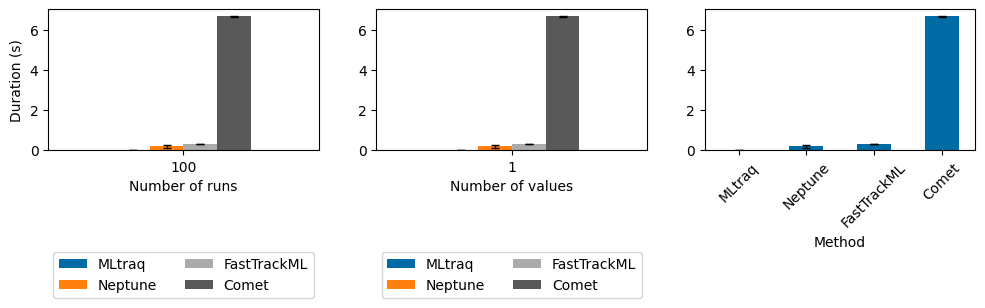


Averaged results by method



,duration,ratio_to_best
method,,
MLtraq,0.013279,1.000000
Neptune,0.183041,13.784342
FastTrackML,0.313169,23.583979
Comet,6.665897,501.991641


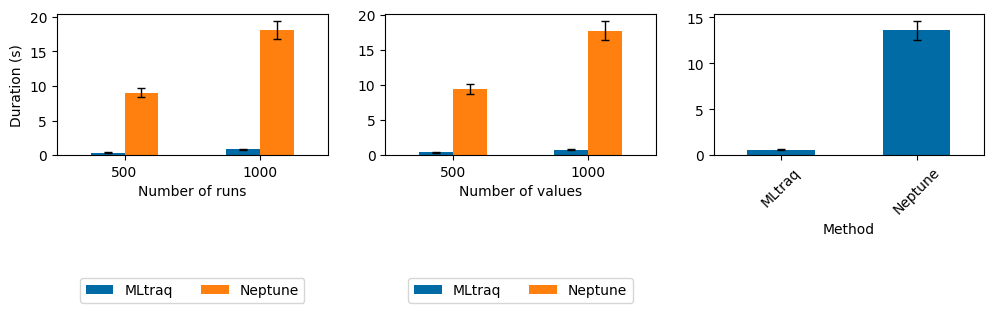


Averaged results by method



,duration,ratio_to_best
method,,
MLtraq,0.590053,1.000000
Neptune,13.579130,23.013418


In [51]:
# Create an MLtraq session to reload the benchmarks
session = mltraq.create_session("sqlite:///local/benchmarks_rev1.db")

# Save plots to SVG files
report_results(
    session.load("exp-1"),
    save_svg_to="../mkdocs/assets/img/benchmarks/exp-1.svg",
)
report_results(
    session.load("exp-2"),
    save_svg_to="../mkdocs/assets/img/benchmarks/exp-2.svg",
)
report_results(
    session.load("exp-3"),
    save_svg_to="../mkdocs/assets/img/benchmarks/exp-3.svg",
)
report_results(
    session.load("exp-4"),
    save_svg_to="../mkdocs/assets/img/benchmarks/exp-4.svg",
)
report_results(
    session.load("exp-5"),
    save_svg_to="../mkdocs/assets/img/benchmarks/exp-5.svg",
)

## Conclusion

In the experiments, MLtraq is, on average, 5-25x faster than the other methods. The speedup of MLtraq against the most popular choices on workloads with hundreds of thousands of runs and tracked values are even more accentuated and above 100x. If speed is among your priorities, you should consider MLtraq to run your experiments. The primary disadvantage of MLtraq is its lack of a complete web dashboard.
